<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT23/blob/main/template-report-Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

In this report, the effect on an elastic mesh of three moving circular holes in the domain are studied.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

In this lab, we look at the way an elastic mesh moves when three circles are moved inside the mesh. To do this, we use the elasticty equation:

$$-\nabla \cdot \sigma = f$$

We can change the parameters of the material, which affects how elastic the material is. More specifically, we cah change Poisson's ratio, $\nu$, which is a mesure of how much a material deforms under a force acting on it ([Linear elasticity](https://cns.gatech.edu/~predrag/GTcourses/PHYS-4421-04/lautrup/7.7/elastic.pdf), p.173).

Another factor that affects the elasticity of a material is Young's modulos, $E$, which affects the stiffness of a material when a force is applied. ([Linear elasticity](https://cns.gatech.edu/~predrag/GTcourses/PHYS-4421-04/lautrup/7.7/elastic.pdf), p.172)



# **Method**
Firstly, we look at how the material of the elastic mesh acts when we change the material properties, namely Young's modulus and Poisson's ratio. This is done by changing

```
E = 1.0e10

```
and


```
nu = 0.3.
```
We also want to change how the circles move, and look at how the mesh behaves then. This is done by changing the boundry conditions

```
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)
```
 which controls how much the circles moves in the x- and y-direction.





**Define domain and mesh**

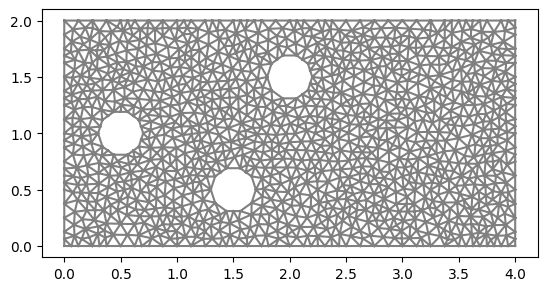

In [ ]:
# Define rectangular domain
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

#d = Function(V)
d_temp = project(as_vector((0,2)), V)
d_bc = DirichletBC(V, d_temp , "(0,2)")
d = Function(V)
d_bc.apply(d.vector())
#d = Expression(("0.5*L","0"), L=L, H=H, element = V.ufl_element())


**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

# **Results**

In this section, we look at the result from the previous section. First, we vary Young's modulus, between $0.0001\cdot 10^{10}$ to $1000\cdot 10^{10}.$ The result can be found in Figure 1. We can see that increasing the value of E makes the material stretch and deform more.

![picture](http://drive.google.com/uc?export=view&id=1S2ADmB5YR2AiRAywY84HZGZkHM-rlbDd)

***Fig 1: Changing the value of Young's modulus E, E =  0.0001,0.1, 1, 10, 1000***

Then, we change Poisson's ratio and look at how the deformation of the mesh changes. The result can be found in Figure 2. As we can see, a higher value of $\nu$ gives a slightly larger stretching and deformation of the mesh.

![picture](http://drive.google.com/uc?export=view&id=1ClwtoViYsJ9Lqw_9sATyVLxBSdxxKQCm)

***Fig 2: Changing the value of Poisson's ratio nu, nu = 0.1, 0.2, 0.4****

We can also create a combination of Yong's modulous and Poisson's ratio that correspond to a material. In Figure 3, we can see the mesh stretching for rubber ($E= 0.01 ⋅ 10^{10}, \nu = 0.4999$) and steel ($E= 20 ⋅ 10^{10}, \nu = 0.3$) (from table of material parameters), where we can see that the rubber stretches much more.
![picture](http://drive.google.com/uc?export=view&id=1lb84EgBU3M-W4SgloHQz63M0hwkpSPxR)

***Fig 3: Mesh deformation for rubber and steel, respectively***

Finally, we look at how different movments of the circles affect the mesh. The result can be found in Figure 4. A smaller movment of the circles makes the mesh deform less, and a bigger movement deforms it more. The direction of the deformation is also affected, since the first two cases only move in the x-direction, and the third case moves diagonally.
![picture](http://drive.google.com/uc?export=view&id=1nuS1lmqgzD8p7wiiat_GOYLwO_ZLHbSx)

***Fig 4: Varying amounts of movement of the circles***



**Define and solve variational problem**

In [ ]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
#E = 1.0e10
#E = 10.0e10
#E = 100.0e10
#E = 1000.0e10
E = 0.0001e10

nu = 0.3
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")

18

**Visualize solution and export files**

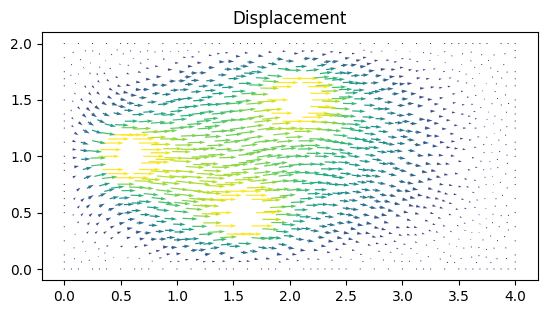

In [ ]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Update mesh**

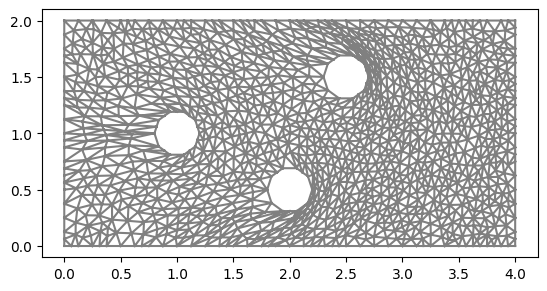

In [ ]:
ALE.move(mesh, d)
plt.figure()
plot(mesh)
plt.show()

# **Discussion**

In this report, the deformation of an elastic mesh was studied by varying the movement of three circles inside the domain. The effect on different material parameters on the deformation was also studied. As expected, both movement and the material of the elastic mesh affect how much it deforms.  